In [2]:
teh idea is to create simple proxies of problems of different types
instead of attacking complex in algorithms and amont and noisyness of data at the same time

SyntaxError: invalid syntax (<ipython-input-2-61eba683bf99>, line 1)

In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display, Image
import PIL
from io import BytesIO
import skimage
from skimage.draw import circle
import random
import sklearn
import sklearn.linear_model
from matplotlib import pyplot as plt
%matplotlib inline

In [436]:
dim_image=64
def display_as_images(ar):
    a=ar[0]
    bar=np.ones([dim_image,2])
#    im_ar=np.hstack([np.hstack([ar[i].reshape([dim_image,dim_image]),bar]) for i in range(ar.shape[0])])
    im_ar=np.hstack([np.hstack([ar[i],bar]) for i in range(ar.shape[0])])
    im = PIL.Image.fromarray(im_ar*255)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    return im

In [437]:
def draw_box(a, y, x, r_max):
    r=random.randint(r_max//2,r_max)
    rr, cc = skimage.draw.polygon_perimeter([y+r,y-r,y-r,y+r],[x-r,x-r,x+r,x+r])
    a[rr, cc] = 1

def draw_circle(a,y,x,r_max):
    #r=random.randint(r_max//2,r_max)
    r=r_max
    rr, cc = skimage.draw.circle_perimeter(y,x,r)
    a[rr, cc] = 1


In [438]:
def gen_item(cnts):
    a=np.zeros([dim_image,dim_image],dtype=np.float32)
    rad = 8
    size = rad * 2 + 2
    steps = dim_image // size
    positions = [( rad+ i // steps *size,rad+ i % steps *size ) for i in range(steps*steps)]
    #print(positions)
    random.shuffle(positions)
    cnt=cnts[0]
    for pos in positions[:cnt]:
        draw_circle(a,pos[0], pos[1], rad)
    positions=positions[cnt:]
    cnt=cnts[1]
    for pos in positions[:cnt]:
        draw_box(a,pos[0], pos[1], rad-2)
    positions=positions[cnt:]
    return a

#gen_item(1)

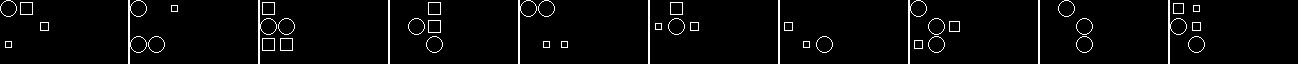

In [443]:
cnt_samples = 200
max_objects = 4 
X_train=[]
Y_train=[]
for i in range(cnt_samples):
    cnt_circles=random.randint(0,3)
    cnt_boxes=random.randint(0,3)
    img = gen_item([cnt_circles, cnt_boxes])
    img = np.hstack([img,np.zeros((dim_image,dim_image),dtype=np.float32)])
    X_train.append(img)
    Y_train.append(np.array([cnt_circles,cnt_boxes],dtype=np.float32))
X_train=np.array(X_train)
Y_train=np.array(Y_train)
display_as_images(X_train[:10])

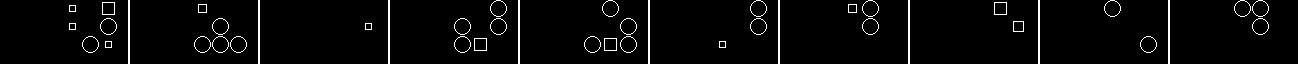

In [444]:
X_test=[]
Y_test=[]
for i in range(100):
    cnt_circles=random.randint(0,4)
    cnt_boxes=random.randint(0,4)
    img = gen_item([cnt_circles, cnt_boxes])
    img = np.hstack([np.zeros((dim_image,dim_image),dtype=np.float32),img])
    X_test.append(img)
    Y_test.append(np.array([cnt_circles,cnt_boxes],dtype=np.float32))
X_test=np.array(X_test)
Y_test=np.array(Y_test)
display_as_images(X_test[:10])

In [445]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import training
from chainer.training import extensions

In [446]:
X_train=np.expand_dims(X_train, axis=1)
X_test=np.expand_dims(X_test, axis=1)


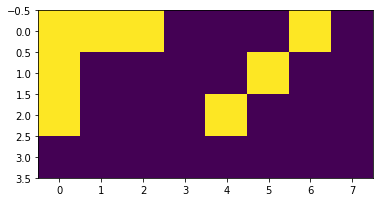

In [447]:
w1 = np.zeros((4,4),dtype=np.float32)
w1[0,0]=1
w1[0,1]=1
w1[0,2]=1
w1[1,0]=1
w1[2,0]=1

w2 = np.zeros((4,4),dtype=np.float32)
w2[2,0]=1
w2[1,1]=1
w2[0,2]=1

w=np.stack([w1,w2])
w=w[:,np.newaxis,:]
w.shape
plt.imshow(np.hstack([w1,w2]))



In [984]:
class CNN(chainer.Chain):

    def __init__(self, train=True):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(1, 16, 4, pad=3), #Convolution2D(in_channels, out_channels, ksize, stride=1, pad=0, wscale=1, bias=0, nobias=False, use_cudnn=True, initialW=None, initial_bias=None, deterministic=False)
            #conv1=L.Convolution2D(1, 2, 4, pad=3, initialW=w, initial_bias=np.array([-4,-2], dtype=np.float32)) ,
            conv2=L.Convolution2D(None, 2, 3, pad=2),
            #conv3=L.Convolution2D(None, 2, 3, pad=2),
            #l1=L.Linear(None, 2, initialW=np.array([[0,0.26],[1,0]],dtype=np.float32)),  
            l1=L.Linear(None, 2),  
        )
        self.train = train

    def get_features(self,x):
        h=x
        #h = F.relu(self.conv1(h))
        h = F.leaky_relu(self.conv1(h))
        h = F.leaky_relu(self.conv2(h))
        #h = F.max_pooling_2d(h, 2)
        #h = F.relu(self.conv3(h))
        return h
    
    def __call__(self, x):
        h = self.get_features(x)
        h = F.sum(h,axis=(2,3))
        h = self.l1(h)
        return h
        ##return F.sigmoid(self.l1(h))
net = CNN()
#net.cleargrads()

In [985]:
#print(net.conv1.W.grad)

In [986]:
#net.__call__(X_train[:10]).data[1]
#net.conv1.W.data


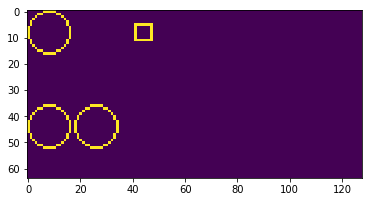

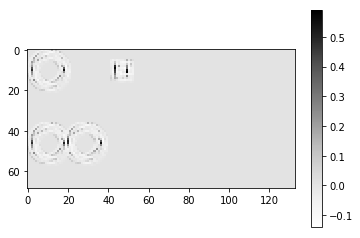

(2, 69, 133)
[-0.73295593 -3.76662827]


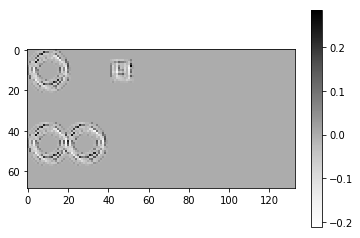

In [1263]:
plt.imshow(X_train[1][0])
plt.show()
result = net.get_features(X_train[:4]).data
plt.imshow(result[1][0],cmap=mpl.cm.Greys)
plt.colorbar()
plt.show()
plt.imshow(result[1][1],cmap=mpl.cm.Greys)
plt.colorbar()
print (result[1].shape)
print (result[1].sum(axis=(1,2)))

In [988]:
r = result[0]
print(r.shape)
F.sum(r,axis=(1,2)).data


(2, 69, 133)


array([ 111.09544373,  190.59375   ], dtype=float32)

In [989]:
net.__call__(X_train[:10]).data[0].shape


(2,)

In [1257]:
1

1

In [990]:
class Model(chainer.Chain):
    def __init__(self, predictor):
        super().__init__(predictor=predictor)

    def __call__(self, x, t):
        y = self.predictor(x)
        #print("y_shape:", y.shape)
        #print("t_shape:", t.shape)
        #loss = F.softmax_cross_entropy(y, t)
        loss = F.mean_absolute_error(y, t)        
        #print(loss.data)
#        loss = F.si(y, t)
#        accuracy = F.accuracy(y, t)
        #accuracy = F.binary_accuracy(y, t)
        chainer.report({'loss': loss}, self)
        return loss

In [ ]:
model = Model(net)

In [ ]:
model.__call__(X_train[:10], Y_train[:10])

In [993]:
#model = Classifier(CNN())
#chainer.cuda.get_device(0).use()
#model.to_gpu()

In [1332]:
#optimizer = chainer.optimizers.SGD(lr=0.000001)
optimizer = chainer.optimizers.Adam(alpha=0.00001)
optimizer.setup(model)
#model.predictor.conv1.enable_update()


In [1333]:
#add channel dimension to X
#print(X_train.shape)
#tmp = np.expand_dims(X_train, axis=1)
#tmp.shape
#Y_train.shape

In [1346]:
train = chainer.datasets.tuple_dataset.TupleDataset(X_train,Y_train)
test  = chainer.datasets.tuple_dataset.TupleDataset(X_test,Y_test)
print(train[2][0].shape)
print(train[2][1])

train_iter = chainer.iterators.SerialIterator(train, batch_size=128)
test_iter  = chainer.iterators.SerialIterator(test, batch_size=32, repeat=False, shuffle=False)
#train[3][1]

(1, 64, 128)
[ 2.  3.]


In [1347]:
#train_iter.values

In [1348]:
#updater = training.StandardUpdater(train_iter, optimizer, device=0)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (100, 'epoch'), out='result')    

In [1349]:
#trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss']))
#trainer.extend(extensions.ProgressBar())

In [ ]:
%%time

trainer.run()

epoch       main/loss   validation/main/loss
1           0.136938    0.166007              
2           0.125087    0.169732              
3           0.151567    0.166983              
4           0.129889    0.166376              
5           0.140602    0.166171              
6           0.133283    0.167068              
7           0.132273    0.167427              
8           0.139804    0.167196              
9           0.131908    0.167463              
10          0.1262      0.168598              
11          0.138876    0.16814               
12          0.120726    0.168675              
13          0.143403    0.168055              
14          0.12225     0.171654              
15          0.134473    0.167286              
16          0.137714    0.167374              


In [ ]:
1

In [1146]:
#vis filters
c=0
for i in model.params():
    print (i)
    c+=1
    if c>4:   break

W
b
W
b
W


In [1147]:
predictor= model.predictor

In [1102]:
for i in net.children():
    print(i)

In [ ]:
c1 = net.conv1

In [1104]:
#c1.W.data
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [1105]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

In [1106]:
W =chainer.cuda.to_cpu(c1.W.data)
W = np.squeeze(W)
print("W shape : ", W.shape)


W shape :  (16, 4, 4)


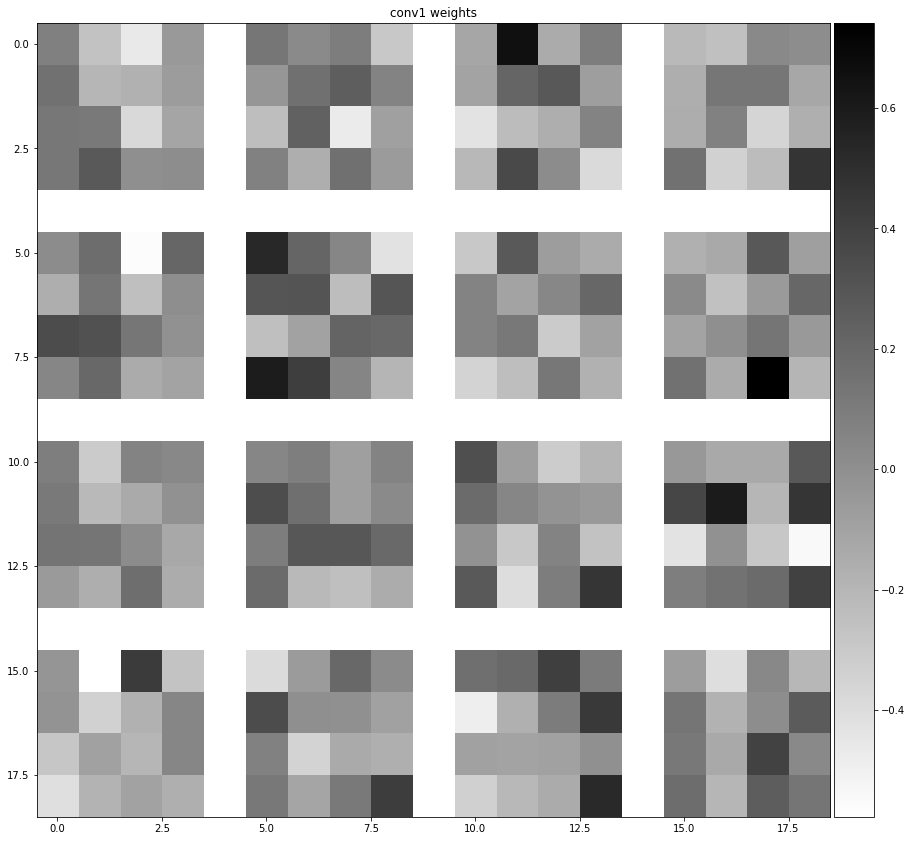

In [1107]:
plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W, 4, 4), cmap=mpl.cm.binary)

In [952]:
class CNN(chainer.Chain):
    def __init__(self, train=True):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(1, 1, 1, initialW=np.array([[[[1]]]])) ,
            l1=L.Linear(None, 1, initialW=np.array([[1,1,1,1]]))  
        )
        self.train=train
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.sigmoid(self.l1(h))
        return h
net = CNN()
net.cleargrads()
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)
#net.conv1.W.update_rule.enabled=False
#net.conv1.W.update_rule.enabled=False
net.conv1.disable_update()
result = net(np.random.random((1,1,2,2)).astype(np.float32))
print("conv1 weights:",net.conv1.W.data)
print("l1 weigths:",net.l1.W.data)
loss = F.mean_absolute_error(result,np.array([[0.1]],dtype=np.float32))
loss.backward()
optimizer.update()
print("after update...")
#print("conv1 grad",net.conv1.W.grad)
print("conv1 weights:",net.conv1.W.data)
print("l1 weights:",net.l1.W.data)


conv1 weights: [[[[ 1.]]]]
l1 weigths: [[ 1.  1.  1.  1.]]
after update...
conv1 weights: [[[[ 1.]]]]
l1 weights: [[ 0.99869204  0.99978     0.999731    0.9996931 ]]


In [326]:
net.conv1.disable_update()
net.conv1.update_enabled
#print (net.conv1.W.update_rule)

False

In [255]:
from chainer import Variable
x_data = np.array([5], dtype=np.float32)
x = Variable(x_data)

In [256]:
y = x**2 - 2 * x + 1
y.data

array([ 16.], dtype=float32)

In [258]:
y.backward()
x.grad

array([ 8.], dtype=float32)